# Analysis for the Modeling Game

In [1]:
%matplotlib inline
import copy
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint

import constants as cn
import tellurium as te
import gene_network as gn
import modeling_game as mg
import model_fitting as mf
import gene_analyzer as ga
import run_game as rg
import util

## Stress Tests

- Decrease Vm8 by 50% and increase Vm3 by 50%
- Show P1

In [65]:
def simulate(parameters=None):
    """
    Runs the simulation for the default model file.
    :return pd.Series, pd.Series, RoadRunner: time, P1, road runner instance
    """
    model = rg.getModel()
    result = mf.runSimulation(model=model,
                              parameters=parameters,
                              sim_time=1200, num_points=120)
    df_protein = mg.makeDF(result.data, is_mrna=False)
    return df_protein.index, df_protein["P1"], result.road_runner

def getP1Data(is_adjust=False):
    """
    Obtains P1 data and time information.
    :param bool is_adjust: if True, perturb Vm8, Vm3
    :return pd.Series, pd.Series: time, P1
    """
    _, _, road_runner = simulate()
    if is_adjust:
        perturb = 0.5
    else:
        perturb = 0.0
    vm8 = perturb*road_runner.Vm8
    vm3 = (1 + perturb)*road_runner.Vm3
    parameters = mg.makeParameters(['Vm8', 'Vm3'], [vm8, vm3])
    ser_time, ser_p1, road_runner = simulate(parameters=parameters)
    print("Vm3: %f\nVm8: %f" % (road_runner.Vm3, road_runner.Vm8))
    return ser_time, ser_p1

Vm3: 1.613831
Vm8: 0.500000


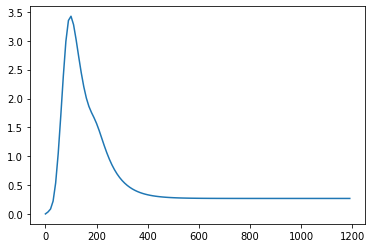

In [66]:
ser_time, ser_p1 = getP1Data()
plt.plot(ser_time, ser_p1)

Vm3: 2.000000
Vm8: 0.500000


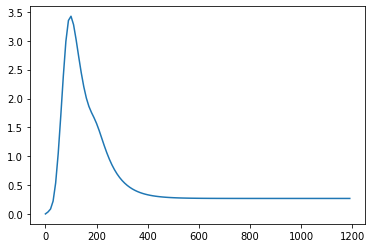

In [67]:
# Fails the stress test since no shift in the peak. See "Final_stress_tests.pptx"
ser_time, ser_p1 = getP1Data(is_adjust=True)
plt.plot(ser_time, ser_p1)

## Model Identification


In [ ]:
analyzers = []

In [ ]:
analyzers.append(evaluate(["1+4"], max_iteration=20, start_time=0, end_time=1200))

In [ ]:
analyzers.append(evaluate(["2+4"], max_iteration=20, start_time=0, end_time=1200))

In [ ]:
analyzers.append(evaluate(["3+6"], max_iteration=20, start_time=0, end_time=1200))

In [ ]:
analyzers.append(evaluate(["4-2A-5"], max_iteration=20, start_time=0, end_time=1200))

In [ ]:
analyzers.append(evaluate(["5+6"], max_iteration=20, start_time=0, end_time=1200))

In [ ]:
analyzers.append(evaluate(["6+7A-1"], max_iteration=20, start_time=0, end_time=1200))

In [ ]:
analyzers.append(evaluate(["7-8"], max_iteration=20, start_time=0, end_time=1200))

In [ ]:
analyzers.append(evaluate(["8-1"], max_iteration=30, start_time=0, end_time=1200))

## Saving an Identified Simulation Model

In [ ]:
# Builds a complete simulation model from the separate analyzers.
# Saves the models and parameters to files
df_params, model = rg.saveAnalysisResults(analyzers)

In [ ]:
df_params

In [ ]:
print(model)

## Running a Saved Model

In [ ]:
# Reads the model and parameters from a file. Fits the parameters. Plots the results.
rg.runModel()

## Correlation Analysis
The goal here is to gain intuition about possible TF configurations for genes.

1. Construct cross correlatons between mRNA and proteins at different time lags. Plt as heatmap.

In [ ]:
df_mrna = pd.read_csv("wild.csv")
df_mrna = df_mrna.set_index("time")

In [ ]:
df_protein = pd.read_csv("wild_protein.csv")
df_protein = df_protein.set_index("time")

In [ ]:
def correlate(df1, df2, lag=0):
    """
    Constructs the correlation with the specified lag
    for df2. Assumes that df1 and df2 have different columns.
    """
    def truncate(df, is_front=True):
        if is_front:
            df_trunc = df.loc[df.index[lag:], :]
        else:
            if lag == 0:
                df_trunc = df
            else:
                df_trunc = df.loc[df.index[:-lag], :]
        df_trunc.index = range(len(df_trunc))
        return df_trunc
    # Adjust lengths
    indices = range(len(df1) - lag)
    df1_trunc = truncate(df1, is_front=False)
    df2_trunc = truncate(df2, is_front=True)
    df_tot = pd.concat([df1_trunc, df2_trunc], axis=1)
    # Correlate and select columns
    df_corr = df_tot.corr()
    columns2 = df2.columns
    df_result = df_corr[columns2].copy()
    df_result = df_result.drop(columns2)
    return df_result

In [ ]:
correlate(df_protein, df_mrna, lag=0)

In [ ]:
correlate(df_protein, df_mrna, lag=1)

In [ ]:
correlate(df_protein, df_mrna, lag=2)

In [ ]:
correlate(df_protein, df_mrna, lag=3)